In [33]:
# "The social benefits of emotion variability"
# Analysis script for Study 4 
# Evan W. Carr, 05-22-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline  

# Set working directory to location of data files, and read in .csv's:
rawData = pd.read_csv("manic7_exptrun_final_clean_17_09_21.csv")
rawDemog = pd.read_csv("demographics_survey_survey_17_09_21.csv")

rawData.head(20)

,date,time,group,subject,build,blocknum,trialnum,blockcode,trialcode,pretrialpause,...,latency,stimulusnumber1,stimulusitem1,stimulusonset1,stimulusnumber2,stimulusitem2,stimulusonset2,stimulusnumber3,stimulusitem3,stimulusonset3
0,92017,15:59:25,694258123,237498919,5.0.9.0,1,1,expt_intro,expt_intro,0,...,12222,1,"Welcome to the study! During this session, ...",2,1,cbs_logo.jpg,2,1,"If you need to exit the study early, you can d...",2
1,92017,15:59:25,694258123,237498919,5.0.9.0,2,1,lv3_block,lv3_trial,0,...,500,137,WM-029_03_crop.jpg,0,0,0,0,0,0,0
2,92017,15:59:25,694258123,237498919,5.0.9.0,2,2,lv3_block,lv3_trial,0,...,500,125,WM-029_-02_crop.jpg,1,0,0,0,0,0,0
3,92017,15:59:25,694258123,237498919,5.0.9.0,2,3,lv3_block,lv3_trial,0,...,500,134,WM-029_-03_crop.jpg,0,0,0,0,0,0,0
4,92017,15:59:25,694258123,237498919,5.0.9.0,2,4,lv3_block,lv3_trial,0,...,500,142,WM-029_-05_crop.jpg,0,0,0,0,0,0,0
5,92017,15:59:25,694258123,237498919,5.0.9.0,2,5,lv3_block,lv3_trial,0,...,500,133,WM-029_-04_crop.jpg,1,0,0,0,0,0,0
6,92017,15:59:25,694258123,237498919,5.0.9.0,2,6,lv3_block,lv3_trial,0,...,500,148,WM-029_04_crop.jpg,0,0,0,0,0,0,0
7,92017,15:59:25,694258123,237498919,5.0.9.0,2,7,lv3_block,lv3_trial,0,...,500,128,WM-029_04_crop.jpg,0,0,0,0,0,0,0
8,92017,15:59:25,694258123,237498919,5.0.9.0,2,8,lv3_block,lv3_trial,0,...,500,141,WM-029_-06_crop.jpg,1,0,0,0,0,0,0
9,92017,15:59:25,694258123,237498919,5.0.9.0,2,9,lv3_block,lv3_trial,0,...,500,149,WM-029_05_crop.jpg,0,0,0,0,0,0,0


In [34]:
# All subjects should have 206 observations (rows) in the dataset ...
# Any that do not have 206 did not finish the study, and need to be removed before analysis:
rawObsCount = rawData.groupby('subject', as_index=False).size().reset_index(name='counts')
rawObsCount.sort_values(by='counts').head(20)

,subject,counts
82,493026361,1
23,150572915,8
88,542399653,8
50,316298674,10
65,386841887,66
36,202214395,66
60,376503020,77
152,943762017,140
105,609873923,206
106,617200915,206


In [35]:
# Create list of subject ID's to exclude:
exclSbj = rawObsCount.query('counts != 206')
exclSbj = np.array(exclSbj['subject'])
exclSbj

array([150572915, 202214395, 316298674, 376503020, 386841887, 493026361,
       542399653, 943762017], dtype=int64)

In [36]:
# Filter to important columns, and exclude subjects that didn't finish the study:
cleanCols = ['subject', 'blocknum', 'trialnum', 'blockcode', 'trialcode', 'response', 'latency', 'stimulusitem1']
cleanData = rawData.loc[~rawData['subject'].isin(exclSbj)][cleanCols]
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1
0,237498919,1,1,expt_intro,expt_intro,57.0,12222,"Welcome to the study! During this session, ..."
1,237498919,2,1,lv3_block,lv3_trial,0.0,500,WM-029_03_crop.jpg
2,237498919,2,2,lv3_block,lv3_trial,0.0,500,WM-029_-02_crop.jpg
3,237498919,2,3,lv3_block,lv3_trial,0.0,500,WM-029_-03_crop.jpg
4,237498919,2,4,lv3_block,lv3_trial,0.0,500,WM-029_-05_crop.jpg


In [37]:
# Quickly check subject times to complete the study (should usually be between 3-6 minutes):
completionTimes = cleanData.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes['latency_mins'] = (completionTimes['latency'] / 1000) / 60
completionTimes.head(20)

,subject,latency,latency_mins
0,5597638,260332,4.338867
1,6037576,215187,3.586450
2,14372200,229384,3.823067
3,16538012,181509,3.025150
4,30208009,211837,3.530617
5,30376333,261642,4.360700
6,45551122,220080,3.668000
7,56565656,252953,4.215883
8,56760620,532253,8.870883
9,63700112,463010,7.716833


In [38]:
# Get quick demographics summary, without excluded subjects:
demogSummary = rawDemog.groupby('subject').agg({'age_response': np.mean, "gender_response": pd.Series.unique}).reset_index()
demogSummary = demogSummary[~demogSummary['subject'].isin(exclSbj)]

demogSummary['age_response'].mean()

36.019354838709674

In [39]:
demogSummary['age_response'].std()

11.75699347983829

In [40]:
demogSummary['gender_response'].value_counts()

Female    97
Male      58
Name: gender_response, dtype: int64

In [41]:
# Create column for emotion variability condition ('model_block'):
cleanData = cleanData.join(cleanData['blockcode'].str.split('_', 1, expand=True).rename(columns={0:'model_block', 1:'junk'}))
cleanData = cleanData.drop(['junk'], axis=1)
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block
0,237498919,1,1,expt_intro,expt_intro,57.0,12222,"Welcome to the study! During this session, ...",expt
1,237498919,2,1,lv3_block,lv3_trial,0.0,500,WM-029_03_crop.jpg,lv3
2,237498919,2,2,lv3_block,lv3_trial,0.0,500,WM-029_-02_crop.jpg,lv3
3,237498919,2,3,lv3_block,lv3_trial,0.0,500,WM-029_-03_crop.jpg,lv3
4,237498919,2,4,lv3_block,lv3_trial,0.0,500,WM-029_-05_crop.jpg,lv3


In [42]:
# Map emotion variability condition ('model_block') to umbrella factor: 
varDict = {'expt': 'expt',
           'lv1': 'lv',
           'lv2': 'lv',
           'lv3': 'lv',
           'hv1': 'hv',
           'hv2': 'hv',
           'hv3': 'hv'}

cleanData['model_block'] = cleanData['model_block'].map(varDict)
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block
0,237498919,1,1,expt_intro,expt_intro,57.0,12222,"Welcome to the study! During this session, ...",expt
1,237498919,2,1,lv3_block,lv3_trial,0.0,500,WM-029_03_crop.jpg,lv
2,237498919,2,2,lv3_block,lv3_trial,0.0,500,WM-029_-02_crop.jpg,lv
3,237498919,2,3,lv3_block,lv3_trial,0.0,500,WM-029_-03_crop.jpg,lv
4,237498919,2,4,lv3_block,lv3_trial,0.0,500,WM-029_-05_crop.jpg,lv


In [43]:
# Access and log stimulus model ID codes for inclusion in mixed-effects models (shown later):
ratingsList = ['authenticity_slider', 'power_slider', 'trust_slider', 'happiness_slider']
modelSummary = cleanData.groupby(['subject', 'blocknum']).agg({"stimulusitem1": pd.Series.unique}).reset_index()

modelSummary.head(10)

,subject,blocknum,stimulusitem1
0,5597638,1,"Welcome to the study! During this session, ..."
1,5597638,2,"[WM-006_-05_crop.jpg, WM-006_05_crop.jpg, WM-0..."
2,5597638,3,"[WM-016_-10_crop.jpg, WM-016_04_crop.jpg, WM-0..."
3,5597638,4,"[WM-029_-02_crop.jpg, WM-029_09_crop.jpg, WM-0..."
4,5597638,5,"[WM-003_05_crop.jpg, WM-003_-04_crop.jpg, WM-0..."
5,5597638,6,"[WM-033_-07_crop.jpg, WM-033_-03_crop.jpg, WM-..."
6,5597638,7,"[WM-009_-06_crop.jpg, WM-009_-05_crop.jpg, WM-..."
7,5597638,9,All done with the study! Thank you for your p...
8,6037576,1,"Welcome to the study! During this session, ..."
9,6037576,2,"[WM-006_05_crop.jpg, WM-006_-11_crop.jpg, WM-0..."


In [44]:
# 'modelSummary' dataframe shows all unique stimuli shown to each subject, by blocknum ...
# Not useful yet, but will be if we can split stimulus names apart:
modelList = []
for i in range(0, modelSummary.shape[0]):
    modelID = modelSummary.iloc[i]['stimulusitem1'][0].split('_', 1)[0]
    modelList.append(modelID)
    
modelSummary['model_id'] = modelList
modelSummary = modelSummary.drop('stimulusitem1', axis=1)

modelSummary.head(10)

,subject,blocknum,model_id
0,5597638,1,W
1,5597638,2,WM-006
2,5597638,3,WM-016
3,5597638,4,WM-029
4,5597638,5,WM-003
5,5597638,6,WM-033
6,5597638,7,WM-009
7,5597638,9,A
8,6037576,1,W
9,6037576,2,WM-006


In [45]:
# Subjects only saw real stimuli in blocknum's 2-7 ...
# Do an inner join with the main data to get only those blocks, then filter to only when subjects gave ratings:
cleanRatings = pd.merge(cleanData, modelSummary, on=('subject', 'blocknum'), how='inner')
cleanRatings = cleanRatings.loc[(cleanRatings['model_block'] != 'expt') & (cleanRatings['trialcode'].isin(ratingsList)), :]
cleanRatings = cleanRatings.drop(['blocknum', 'trialnum', 'blockcode', 'stimulusitem1'], axis=1)

cleanRatings.head(20)

,subject,trialcode,response,latency,model_block,model_id
31,237498919,happiness_slider,69.0,43112,lv,WM-029
32,237498919,power_slider,62.0,15549,lv,WM-029
33,237498919,trust_slider,81.0,11218,lv,WM-029
34,237498919,authenticity_slider,66.0,10918,lv,WM-029
65,237498919,trust_slider,88.0,12092,hv,WM-033
66,237498919,power_slider,71.0,15994,hv,WM-033
67,237498919,authenticity_slider,92.0,6121,hv,WM-033
68,237498919,happiness_slider,71.0,9800,hv,WM-033
99,237498919,happiness_slider,55.0,11040,lv,WM-006
100,237498919,authenticity_slider,79.0,7516,lv,WM-006


In [46]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("trialcode == 'authenticity_slider'")
powerData = cleanRatings.query("trialcode == 'power_slider'")
trustData = cleanRatings.query("trialcode == 'trust_slider'")
happinessData = cleanRatings.query("trialcode == 'happiness_slider'")

In [47]:
# Run mixed-effects models on each DV:
#    - fixed = variability (high vs. low)
#    - random = subject & model_id (will add model_id random-effects in R models later)

a_m1 = smf.mixedlm("response ~ model_block", data=authenticityData, groups=authenticityData['subject']).fit()
print(a_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   930      Method:              REML      
No. Groups:         155      Scale:               394.7142  
Min. group size:    6        Likelihood:          -4143.0334
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         57.720    1.095 52.729 0.000 55.575 59.866
model_block[T.lv] -1.946    1.303 -1.494 0.135 -4.500  0.608
groups RE         54.160    0.753                           



In [48]:
p_m1 = smf.mixedlm("response ~ model_block", data=powerData, groups=powerData['subject']).fit()
print(p_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   930      Method:              REML      
No. Groups:         155      Scale:               353.9891  
Min. group size:    6        Likelihood:          -4115.1921
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         47.824    1.146 41.745 0.000 45.578 50.069
model_block[T.lv]  3.516    1.234  2.850 0.004  1.098  5.935
groups RE         85.429    0.958                           



In [49]:
t_m1 = smf.mixedlm("response ~ model_block", data=trustData, groups=trustData['subject']).fit()
print(t_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   930      Method:              REML      
No. Groups:         155      Scale:               406.9098  
Min. group size:    6        Likelihood:          -4169.8185
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         51.039    1.174 43.480 0.000 48.738 53.339
model_block[T.lv]  1.254    1.323  0.948 0.343 -1.339  3.847
groups RE         77.942    0.902                           



In [50]:
h_m1 = smf.mixedlm("response ~ model_block", data=happinessData, groups=happinessData['subject']).fit()
print(h_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   930      Method:              REML      
No. Groups:         155      Scale:               437.2757  
Min. group size:    6        Likelihood:          -4209.2778
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         51.447    1.250 41.144 0.000 48.997 53.898
model_block[T.lv] -2.387    1.371 -1.741 0.082 -5.075  0.301
groups RE         96.593    1.011                           



In [51]:
# Models suggest that high-variability leads to greater ratings of authenticity, trust, and happiness -- but not power ...

# Push objects to R to confirm analysis
# (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
# Send datasets with ratings to R: 
%R -i authenticityData,powerData,trustData,happinessData

In [53]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

a_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=authenticityData)
a_m2_anova <- anova(a_m2)
a_m2_lsmeans <- lsmeans(a_m2)
             
p_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=powerData)
p_m2_anova <- anova(p_m2)
p_m2_lsmeans <- lsmeans(p_m2)
                          
t_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=trustData)
t_m2_anova <- anova(t_m2)
t_m2_lsmeans <- lsmeans(t_m2)
                                       
h_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=happinessData)
h_m2_anova <- anova(h_m2)
h_m2_lsmeans <- lsmeans(h_m2)

In [54]:
# Pull model results back to python:
%R -o a_m2_anova,a_m2_lsmeans,p_m2_anova,p_m2_lsmeans,t_m2_anova,t_m2_lsmeans,h_m2_anova,h_m2_lsmeans

In [55]:
pandas2ri.ri2py(a_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,941.53546,941.53546,1,771.109621,2.422164,0.12004


In [56]:
pandas2ri.ri2py(p_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,2289.607886,2289.607886,1,769.753819,6.850424,0.009036


In [57]:
pandas2ri.ri2py(t_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,254.207385,254.207385,1,769.426618,0.694913,0.404757


In [58]:
pandas2ri.ri2py(h_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,1249.542841,1249.542841,1,769.482231,3.159269,0.075892


In [59]:
# R models confirm python results ...

# Create dataset for plotting:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity', 'Authenticity', 'Trust', 'Trust', 'Power', 'Power', 'Happiness', 'Happiness'],
    'variability': ['High', 'Low', 'High', 'Low', 'High', 'Low', 'High', 'Low'],
    'slider_mean': [pandas2ri.ri2py(a_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(a_m2_lsmeans[0]).Estimate[1],
                   pandas2ri.ri2py(t_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(t_m2_lsmeans[0]).Estimate[1],
                   pandas2ri.ri2py(p_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(p_m2_lsmeans[0]).Estimate[1],
                   pandas2ri.ri2py(h_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(h_m2_lsmeans[0]).Estimate[1]],
    'slider_sem': [pandas2ri.ri2py(a_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(a_m2_lsmeans[0])['Standard Error'][1],
                   pandas2ri.ri2py(t_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(t_m2_lsmeans[0])['Standard Error'][1],
                   pandas2ri.ri2py(p_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(p_m2_lsmeans[0])['Standard Error'][1],
                   pandas2ri.ri2py(h_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(h_m2_lsmeans[0])['Standard Error'][1]]
})

# Adjust numbers to start at 45 (plotnine isn't great at scaling charts to non-zero y-axes):
plotData['slider_mean_45'] = plotData['slider_mean']-45
plotData

,rating_type,slider_mean,slider_sem,variability,slider_mean_45
0,Authenticity,57.7554,1.4806,High,12.7554
1,Authenticity,55.7393,1.4806,Low,10.7393
2,Trust,51.1415,2.8599,High,6.1415
3,Trust,52.1897,2.8599,Low,7.1897
4,Power,48.0089,2.1423,High,3.0089
5,Power,51.1545,2.1423,Low,6.1545
6,Happiness,51.4158,2.9107,High,6.4158
7,Happiness,49.0917,2.9107,Low,4.0917


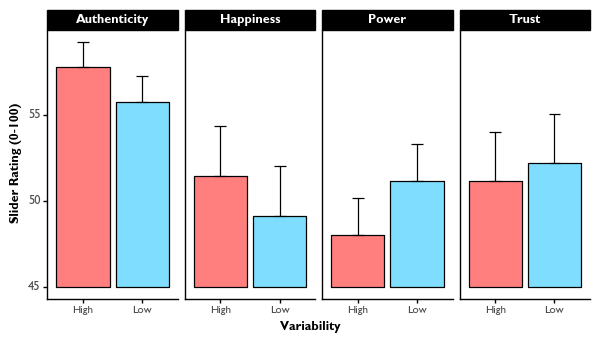

<ggplot: (135282232240)>

In [60]:
# Use plotnine package to plot using ggplot2 (R) style ...
# Manually recoding y-axis labels using 'slider_mean_45' variable (starting y-axis at zero doesn't look good):
(ggplot(plotData, aes(x='factor(variability)', y='slider_mean_45', fill='factor(variability)')) 
 + geom_errorbar(aes(ymax='slider_mean_45 + slider_sem', ymin='slider_mean_45'), position=position_dodge(width=0.9), width=0.2, color='black')
 + geom_bar(stat='identity', position=position_dodge(width=0.9), alpha=0.5, color='black')
 + scale_fill_manual(values=['red', 'deepskyblue'], guide=False)
 + facet_wrap('~ rating_type', nrow=1)
 + scale_y_continuous(labels=['45', '50', '55'])
 + labs(x='Variability', y='Slider Rating (0-100)')
 + theme_classic()
 + theme(figure_size = (7, 3.5),
         text = element_text(family='Gill Sans MT'),
         axis_text_x = element_text(size = 8),
         axis_title_x = element_text(size = 9, weight = 'bold'),
         axis_text_y = element_text(size = 9),
         axis_title_y = element_text(size = 9, weight = 'bold'),
         axis_line_x = element_line(color = 'black'),
         axis_line_y = element_line(color = 'black'),
         strip_text_x = element_text(weight = 'bold', color = 'white', size = 9), 
         strip_background = element_rect(fill = 'black')))